#  SOCAT neural-network : TensorFlow

This notebook contains all the code to run neural network using Tensorflow
Driver data includes: SST, SSS, MLD, CHL, CO2 and we are predicting fCO2

We are starting with monthly gridded observations 1998 - 2010

In [2]:
import tensorflow as tf
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import robust_scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
import os

### Print if using CPU or GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

%matplotlib inline

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2753921689641128354
]


In [1]:
tf.__version__

NameError: name 'tf' is not defined

### All you need to change is data_dir

In [2]:
data_dir='/Users/gloege/Documents/Projects/SOCAT-neural-network/data/data_driver_fixed/'
os.listdir(data_dir)

['SOCATv5_mask_199801-201012.nc',
 'SALT_1x1_199801-201012.nc',
 'MXLDEPTH_1x1_199801-201012.nc',
 'co2_avg_199801-201012.nc',
 'sst_1x1_199801-201012.nc',
 'biomes.nc',
 'SOCATv5_gridded_monthly_199801-201012.nc',
 'Chl_1x1_199801-201012.nc']

# 1. Get the data and sample like it's SOCAT

In [3]:
### SOCAT data paths
fl_mask = data_dir + 'SOCATv5_mask_199801-201012.nc'
fl_socat = data_dir + 'SOCATv5_gridded_monthly_199801-201012.nc'

### Driver data paths
fl_sss = data_dir + 'SALT_1x1_199801-201012.nc'
fl_mld = data_dir + 'MXLDEPTH_1x1_199801-201012.nc'
fl_co2 = data_dir + 'co2_avg_199801-201012.nc'
fl_sst = data_dir + 'sst_1x1_199801-201012.nc'
fl_chl = data_dir + 'Chl_1x1_199801-201012.nc'

### biomes
fl_biomes = data_dir + 'biomes.nc'

In [4]:
### SOCAT data 
ds_mask = xr.open_dataset(fl_mask)
ds_socat = xr.open_dataset(fl_socat)

### Driver data
ds_sss = xr.open_dataset(fl_sss)
ds_mld = xr.open_dataset(fl_mld)
ds_co2 = xr.open_dataset(fl_co2)
ds_sst = xr.open_dataset(fl_sst)
ds_chl = xr.open_dataset(fl_chl)

### Biomes
ds_biomes = xr.open_dataset(fl_biomes)

In [5]:
### Make sure all the same dimensions
print('Make sure all same dimensions and lon starts at 0')
print(ds_mask['socat_mask'].shape, ds_mask['xlon'].values[0])
print(ds_socat['FCO2_AVE_UNWTD'].shape, ds_socat['xlon'].values[0])
print(ds_sss['SALT'].shape, ds_sss['tlon'].values[0])
print(ds_sst['sst'].shape, ds_sst['tlon'].values[0])
print(ds_chl['Chl'].shape, ds_chl['tlon'].values[0])
print(ds_mld['MXLDEPTH'].shape, ds_mld['tlon'].values[0])
print(ds_co2['co2'].shape) 


Make sure all same dimensions and lon starts at 0
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156, 180, 360) 0.5
(156,)


In [6]:
### Grid
lon = ds_socat['xlon']
lat = ds_socat['ylat']
time = ds_socat['tmnth']

### Data
mask = ds_mask['socat_mask'].values
fco2 = ds_socat['FCO2_AVE_UNWTD'].values
sss = ds_sss['SALT'].values
sst = ds_sst['sst'].values
chl = ds_chl['Chl'].values
mld = ds_mld['MXLDEPTH'].values

### This tiles CO2 so same shape as the others.
co2 = np.tile(ds_co2['co2'].values[:, np.newaxis, np.newaxis],(1,180,360))

### Show me the shape of co2
print('The shape of CO2 is now : ' + str(co2.shape))

The shape of CO2 is now : (156, 180, 360)


## One-hot encode the biomes

![mean_biomes](https://doi.pangaea.de/10013/epic.42948.d004)

(156, 180, 360, 18)


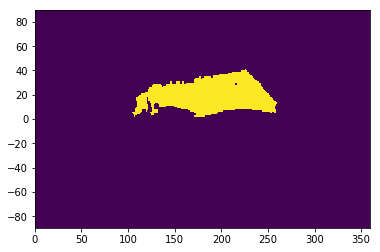

In [7]:
### biomes
fl_biomes = data_dir + 'biomes.nc'

### Get Mean biomes and make lon 0-360
mean_biomes = np.swapaxes(ds_biomes['MeanBiomes'].roll(lon=-180),0,1).values

### biomes_tiled
biomes_tiled = np.tile(mean_biomes[np.newaxis, :, :],(len(time),1, 1))

### Replace nans with zero
biomes_land = np.isnan(mean_biomes)
mean_biomes[biomes_land] = 0

### Use tensorflow to one-hot encode
with tf.Session() as sess:
    biomes_one_hot = sess.run(tf.one_hot(mean_biomes,18))

### Tile biomes_one_hot
biomes_one_hot_tiled = np.tile(biomes_one_hot[np.newaxis, :, :, :],(len(time),1, 1, 1))

### plot one of the biomes
print(biomes_one_hot_tiled.shape)
plt.pcolor(lon,lat,biomes_one_hot[:,:,4])

## Tile lat lon and time

In [8]:
### Define a meshgrid from lon and lat
lon_mesh, lat_mesh = np.meshgrid(lon,lat)

### Tile the meshgrid to the number of time steps
lat_tiled = np.tile(lat_mesh[np.newaxis, :, :],(len(time),1, 1))
lon_tiled = np.tile(lon_mesh[np.newaxis, :, :],(len(time),1, 1))

### Tile time
time_tiled = np.tile(time.values[:, np.newaxis, np.newaxis],(1,180,360))
#time_tiled.shape

## Maximum of each variable
I am taking the max of the unsampled (i.e. not sampled like SOCAT) and dividing this by the vector to normalize it between 0 and 1

This may not be the best way to go, so I commented these lines out

In [9]:
#fco2_max = np.nanmax(fco2)

### drivers
#sss_max = np.nanmax(sss)
#sst_max = np.nanmax(sst)
#chl_max = np.nanmax(chl)
#mld_max = np.nanmax(mld)
#co2_max = np.nanmax(co2)

#print('max sss ' + str(sss_max))
#print('max sst ' + str(sst_max))
#print('max chl ' + str(chl_max))
#print('max mld ' + str(mld_max))
#print('max co2 ' + str(co2_max))

## Mask the data like it is SOCAT

In [9]:
fco2_ma = np.ma.masked_array(fco2, mask=(mask==0))

sst_ma = np.ma.masked_array(sst, mask=(mask==0))
sss_ma = np.ma.masked_array(sss, mask=(mask==0))
chl_ma = np.ma.masked_array(chl, mask=(mask==0))
mld_ma = np.ma.masked_array(mld, mask=(mask==0))
co2_ma = np.ma.masked_array(co2, mask=(mask==0))

In [11]:
#fco2_ma = np.ma.masked_array(fco2_socat, mask=biomes_mask * np.ones(np.shape(fco2)[0])[:, None, None])

#sst_ma = np.ma.masked_array(sst_socat, mask=biomes_mask * np.ones(np.shape(sst)[0])[:, None, None])
#sss_ma = np.ma.masked_array(sss_socat, mask=biomes_mask * np.ones(np.shape(sss)[0])[:, None, None])
#chl_ma = np.ma.masked_array(chl_socat, mask=biomes_mask * np.ones(np.shape(chl)[0])[:, None, None])
#mld_ma = np.ma.masked_array(mld_socat, mask=biomes_mask * np.ones(np.shape(mld)[0])[:, None, None])
#co2_ma = np.ma.masked_array(co2_socat, mask=biomes_mask * np.ones(np.shape(co2)[0])[:, None, None])

#plt.pcolor(lon,lat,sst_ma[100,:,:])

## Driver data in large matrix and output

In [10]:
### What is driving the model
                                ### "classic" predictors
driver = np.transpose(np.stack((sst_ma.flatten(),     # SST
                                sss_ma.flatten(),     # SSS 
                                chl_ma.flatten(),     # Chl
                                mld_ma.flatten(),     # MLD
                                co2_ma.flatten(),     # atm. CO2
                                
                                ### Grid as predictors
                                #lon_tiled.flatten(),  # Longitude
                                #lat_tiled.flatten(),  # Latitude
                                #time_tiled.flatten(), # time
                                
                                ### Biomes are one-hot encoded ###
                                #biomes_one_hot_tiled[:,:,:,0].flatten(), # <-- This one is 1 where there is land
                                biomes_one_hot_tiled[:,:,:,1].flatten(),
                                biomes_one_hot_tiled[:,:,:,2].flatten(),
                                biomes_one_hot_tiled[:,:,:,3].flatten(),
                                biomes_one_hot_tiled[:,:,:,4].flatten(),
                                biomes_one_hot_tiled[:,:,:,5].flatten(),
                                biomes_one_hot_tiled[:,:,:,6].flatten(),
                                biomes_one_hot_tiled[:,:,:,7].flatten(),
                                biomes_one_hot_tiled[:,:,:,8].flatten(),
                                biomes_one_hot_tiled[:,:,:,9].flatten(),
                                biomes_one_hot_tiled[:,:,:,10].flatten(),
                                biomes_one_hot_tiled[:,:,:,11].flatten(),
                                biomes_one_hot_tiled[:,:,:,12].flatten(),
                                biomes_one_hot_tiled[:,:,:,13].flatten(),
                                biomes_one_hot_tiled[:,:,:,14].flatten(),
                                biomes_one_hot_tiled[:,:,:,15].flatten(),
                                biomes_one_hot_tiled[:,:,:,16].flatten(),
                                biomes_one_hot_tiled[:,:,:,17].flatten(),
                                
                                ### Output (what you are trying to predict)
                                fco2_ma.flatten()
                               )))

### What the true value is 
#true_value = fco2_ma.flatten()

print('shape of driver: ' + str(driver.shape))
#print('shape of true_value: ' + str(true_value.shape))

shape of driver: (10108800, 23)


## Remove rows with NaN and train/test split
I am calling these driver_nn and true_value_nn

In [13]:
#nan_mask=(~np.isnan(driver).any(axis=1)) & (~np.isnan(true_value).any(axis=1))
#driver_nn = driver[nan_mask]
#true_value_nn = true_value[nan_mask]
#print('shape of driver_nn: ' + str(driver_nn.shape))
#print('shape of true_value_nn: ' + str(true_value_nn.shape))

In [13]:
df_driver = pd.DataFrame(driver)
df_driver_dropna = df_driver.dropna(axis=0)
df_driver_dropna.head()

### if you want a specific biome
df_driver_biome = df_driver_dropna.loc[df_driver_dropna[8] == 1]
df_driver_biome.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
34015,28.930000,34.513330,0.11705,59.761087,365.0734,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.893005
34375,29.119999,34.479020,0.10873,54.754461,365.0734,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,358.513489
34376,29.080000,34.484479,0.15171,55.791471,365.0734,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,357.626373
35085,29.889999,34.413349,0.06910,55.507925,365.0734,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351.883026
35086,29.830000,34.415154,0.06692,56.740250,365.0734,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.508789


In [14]:
features = df_driver_biome.iloc[:,0:5].as_matrix()
output = df_driver_biome.iloc[:,-1].as_matrix()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, output[:, np.newaxis], random_state=42)
y_train = np.array(y_train)
y_test =  np.array(y_test)
X_train = np.array(X_train)
X_test =  np.array(X_test)

print('shape of X_train: ' + str(X_train.shape))
print('shape of X_test: ' + str(X_test.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of y_test: ' + str(y_test.shape))

shape of X_train: (13515, 5)
shape of X_test: (4506, 5)
shape of y_train: (13515, 1)
shape of y_test: (4506, 1)


In [ ]:
#type(driver[:,1].tolist())
#driver.shape
#batch_size=2
#with tf.Session() as sess:
#    tmp = sess.run(tf.train.batch([1,2,3,4,5,6], 
 #                                 batch_size=batch_size, 
 #                                 capacity=batch_size * 8, 
 #                                 num_threads=4))
                   


<tf.Tensor 'batch_9:0' shape=(1,) dtype=float32>

# Scale the data

In [16]:
#X_train_scale = minmax_scale(X_train, axis=1)
#y_train_scale = minmax_scale(y_train, axis=0)

X_train_scale = normalize(X_train, axis=1)
y_train_scale, y_train_norm = normalize(y_train, axis=0, return_norm=True)

X_test_scale = normalize(X_test, axis=1)
y_test_scale, y_test_norm = normalize(y_test, axis=0, return_norm=True)

print(np.min(X_train_scale), np.max(X_train_scale))
print(np.min(y_train_scale), np.max(y_train_scale))

0.0 0.99451027531
0.00701842943793 0.0113206761424


In [17]:
X_train_scale[:,4] = X_train_scale[:,4]*1.2


# 2. Building a network

In [18]:
### Seed the random numbers
np.random.seed(42)
tf.set_random_seed(42)

### input and output for tf
tf_x = tf.placeholder(tf.float32, X_train.shape)      # input x
tf_y = tf.placeholder(tf.float32, y_train.shape)      # input y

# one layer 400 with 10% dropout is not bad
# one layer 300 with 50% dropout is not bad
### neural network layers (input -> L1 -> L2 -> D1 -> predict)
layer1 = tf.layers.dense(tf_x, 100, activation=tf.nn.relu)    # hidden layer 1
#dropout1 = tf.layers.dropout(layer1, 0.2)                     # Dropout layer 1
# Layer 2 + Dropout 10%
#layer2 = tf.layers.dense(layer1, 20, activation=tf.nn.relu) # hidden layer 2
#dropout2 = tf.layers.dropout(layer2, 0.1)                     # Dropout layer 2
# Layer 3 + Dropout 10%
#layer3 = tf.layers.dense(layer2, 5, activation=tf.nn.relu) # hidden layer 3
#dropout3 = tf.layers.dropout(layer3, 0.1)                     # Dropout layer 3
output = tf.layers.dense(layer1, 1, activation=None)                         # output layer

### Loss and optimzer
loss = tf.losses.mean_squared_error(tf_y, output)   # compute cost
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train_op = optimizer.minimize(loss)
    
### Run model in session
with tf.Session() as sess:   # control training and others
    sess.run(tf.global_variables_initializer())     # initialize var in graph

    ### Train the model
    for step in range(20000):
        # train and net output
        _, l, pred = sess.run([train_op, loss, output], {tf_x: X_train_scale, tf_y: y_train_scale})

        ### Only print each 100th time step
        if (step%1000==0):
            print('epoch =',step, 'loss =',l)

epoch = 0 loss = 0.0434432
epoch = 1000 loss = 1.98352e-07
epoch = 2000 loss = 1.84186e-07
epoch = 3000 loss = 1.87188e-07
epoch = 4000 loss = 3.33506e-07
epoch = 5000 loss = 1.71413e-07
epoch = 6000 loss = 1.72555e-07
epoch = 7000 loss = 5.25533e-05
epoch = 8000 loss = 1.64822e-07
epoch = 9000 loss = 1.83772e-07
epoch = 10000 loss = 1.75934e-07
epoch = 11000 loss = 4.04001e-07
epoch = 12000 loss = 2.3926e-07
epoch = 13000 loss = 1.69935e-07
epoch = 14000 loss = 1.72695e-07
epoch = 15000 loss = 1.72884e-07
epoch = 16000 loss = 1.74003e-07
epoch = 17000 loss = 2.04972e-07
epoch = 18000 loss = 3.37345e-07
epoch = 19000 loss = 1.70801e-07


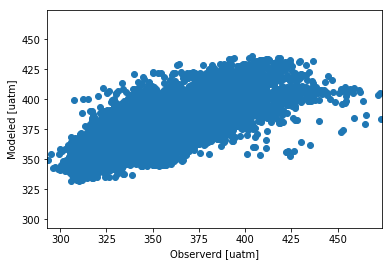

In [19]:
limit=[np.floor(np.min(y_train)), np.ceil(np.max(y_train))]
plt.scatter(y_train, pred*y_train_norm)
plt.xlabel('Observerd [uatm]')
plt.ylabel('Modeled [uatm]')
plt.xlim(limit)
plt.ylim(limit)
plt.show()


In [21]:
fig_dir = '/Users/gloege/Desktop/'
plt.savefig(fig_dir + 'nn_test', 
            transparent=False, 
            dpi=80, 
            bbox_inches="tight")

In [ ]:
 with tf.Session(graph=graph) as sess:
    ckpt = tf.train.get_checkpoint_state('./model/')
    saver.restore(session, ckpt.model_checkpoint_path)
    feed_dict = {tf_train_dataset : batch_data}
    predictions = session.run([test_prediction], feed_dict)

# Keras based model

In [47]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation, Dropout

In [113]:
### Gets the number of features (just number columns in driver)
#number_features = driver.shape[1]

### Model architecture
model = Sequential()
model.add(Dense(100, input_shape=(np.shape(X_train_scale)[1],), activation='relu'))
#model.add(Dropout(0.3))
#model.add(Dense(200, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

### Compile the model
model.compile(optimizer='adam', loss='mse')

### Show topogarphy
model.summary()

### Fit the model
history_callback = model.fit(X_train_scale, y_train_scale, epochs=30, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 100)               600       
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 101       
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [120]:
pred = model.predict(X_test_scale, verbose=1)

4506/4506 [==============================]4506/4506 [==============================] - 0s 26us/step



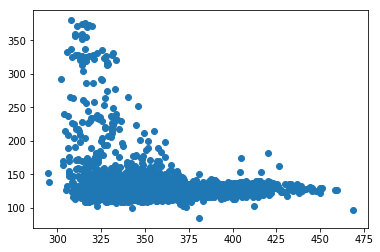

In [121]:
limit=[np.floor(np.min(y_test)), np.ceil(np.max(y_test))]
plt.scatter(y_test, pred*y_train_norm)
#plt.xlim(limit)
#plt.ylim(limit)
plt.show()